In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from xgboost import XGBRegressor
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

## Preparing train samples

In [2]:
data = pd.read_csv("CUP_IT_train_data.csv")

In [3]:
data['dlk_cob_date'] = pd.to_datetime(data['dlk_cob_date'])

In [4]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

# Make copy to avoid changing original data 
label_X_train = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    data[col] = data[col].apply(str)
    label_X_train[col] = label_encoder.fit_transform(data[col])

In [5]:
label_X_train

,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,...,active,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level
0,335992,2018-06-30,17.957530,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,144,46.0,1,2
1,335992,2018-04-30,27.720918,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,142,44.0,1,2
2,335992,2018-05-31,21.949626,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,143,45.0,1,2
3,335992,2018-08-31,14.855459,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,146,48.0,1,2
4,335992,2018-03-31,27.917161,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,141,43.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161778,120605,2018-06-30,52.379263,1,0,1,63,18,0,1,...,1,1,0,1,960.0,34.0,115,31.0,1,2
4161779,120605,2018-02-28,54.218822,1,0,1,63,18,0,1,...,1,1,0,1,960.0,33.0,111,27.0,1,2
4161780,120605,2018-03-31,53.343644,1,0,1,63,18,0,1,...,1,1,0,1,960.0,33.0,112,28.0,1,2
4161781,120605,2018-04-30,52.248182,1,0,1,63,18,0,1,...,1,1,0,1,960.0,34.0,113,29.0,1,2


In [6]:
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train.drop(columns=['dlk_cob_date'])))

# Imputation removed column names; put them back
imputed_X_train.insert(1, 'dlk_cob_date', label_X_train['dlk_cob_date'])
imputed_X_train.columns = label_X_train.columns

### Loading in single thread

In [13]:
users_id = data['cif_id'].unique()[:6000]
size = 43
X_users = np.ndarray(shape=(0, size))
y_users = np.empty(0)
for j in tqdm(np.arange(len(users_id))):
    user = users_id[j]
    current_user_data = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date').drop(columns=['cif_id','dlk_cob_date', 'gi_smooth_3m']).to_numpy()
    gi_smooth_3m = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date')['gi_smooth_3m'].to_numpy()
    for i in np.arange(len(current_user_data) - 6):
        X_users = np.append(X_users, current_user_data[i].reshape((1, size)), axis=0)
        y_users = np.append(y_users, np.asarray([sum(gi_smooth_3m[i + 1:i + 8])]), axis=0)

100%|██████████| 6000/6000 [03:06<00:00, 32.23it/s]


### Loading using multiple threads

In [30]:
%%time
n_threads = 32
users_id = data['cif_id'].unique()[:48000]
def kernel(users):
    size = 43
    X_users_tmp = np.ndarray(shape=(0, size))
    y_users_tmp = np.empty(0)
    for user in users:
        current_user_data = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date').drop(columns=['cif_id','dlk_cob_date', 'gi_smooth_3m']).to_numpy()
        gi_smooth_3m = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date')['gi_smooth_3m'].to_numpy()
        for i in np.arange(len(current_user_data) - 6):
            X_users_tmp = np.append(X_users_tmp, current_user_data[i].reshape((1, size)), axis=0)
            y_users_tmp = np.append(y_users_tmp, np.asarray([sum(gi_smooth_3m[i + 1:i + 8])]), axis=0)
    return X_users_tmp, y_users_tmp

chunks = np.array_split(users_id, n_threads)
pool = ThreadPool(n_threads)
result = pool.map(kernel, chunks)
pool.close()
pool.join()
size = 43
X_users = np.ndarray(shape=(0, size))
y_users = np.empty(0)
for thread_result in result:
    X_users = np.append(X_users, thread_result[0], axis=0)
    y_users = np.append(y_users, thread_result[1], axis=0)

Wall time: 8min 57s


In [13]:
print(np.shape(result[1][1]))

(903,)


In [32]:
X_users.shape

(232169, 43)

### Saving

In [31]:
np.savez_compressed('data_np_large_train', sample=X_users, label=y_users)

### Loading

In [2]:
tmp = np.load('data_np_large_train.npz')
X_users = tmp['sample']
y_users = tmp['label']
X_users.shape

(14699, 44)

## Preparing test data

In [33]:
data_test = pd.read_csv("CUP_IT_test_data.csv")
#data_test = data_test.drop(columns=['rank'])

In [34]:
data_test['dlk_cob_date'] = pd.to_datetime(data_test['dlk_cob_date'])

In [35]:
s = (data_test.dtypes == 'object')
object_cols = list(s[s].index)

# Make copy to avoid changing original data 
label_X_test = data_test.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    data_test[col] = data_test[col].apply(str)
    label_X_test[col] = label_encoder.fit_transform(data_test[col])

In [36]:
label_X_test

,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,...,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level,rank
0,50514,2018-06-30,17.898438,2,1,2,5,14,0,1,...,1,0,1,960.00000,48.0,83,63.0,1,3,5
1,50514,2018-02-28,24.355419,2,1,2,5,14,0,1,...,1,0,1,960.00000,47.0,79,59.0,1,3,1
2,50514,2018-04-30,20.534134,2,1,2,5,14,0,1,...,1,0,1,960.00000,48.0,81,61.0,1,3,3
3,50514,2018-01-31,26.477938,2,1,2,5,14,0,1,...,1,0,1,960.00000,47.0,78,58.0,1,3,0
4,50514,2018-05-31,19.623962,2,1,2,5,14,0,1,...,1,0,1,960.00000,48.0,82,62.0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683767,195116,2018-06-30,215.977387,1,0,2,5,10,1,0,...,0,0,0,2588.73600,35.0,83,150.0,1,3,5
683768,195116,2018-04-30,171.179781,1,0,2,5,10,0,0,...,0,0,0,1407.70872,35.0,81,148.0,1,3,3
683769,195116,2018-05-31,195.262540,1,0,2,5,10,1,0,...,0,0,0,1632.00000,35.0,82,149.0,1,3,4
683770,195116,2018-02-28,126.780871,1,0,2,5,10,0,0,...,0,0,0,1407.70872,35.0,79,146.0,1,3,1


In [37]:
# Imputation
my_imputer = SimpleImputer()
imputed_X_test = pd.DataFrame(my_imputer.fit_transform(label_X_test.drop(columns=['dlk_cob_date'])))

# Imputation removed column names; put them back
imputed_X_test.insert(1, 'dlk_cob_date', label_X_test['dlk_cob_date'])
imputed_X_test.columns = label_X_test.columns

### Loading in single thread

In [13]:
users_id = data_test['cif_id'].unique()[:600]
size = 43
X_users_test = np.ndarray(shape=(0, size))
y_users_test = np.empty(0)
for j in tqdm(np.arange(len(users_id))):
    user = users_id[j]
    current_user_data = imputed_X_test[imputed_X_test.cif_id == user].sort_values(by='dlk_cob_date').drop(columns=['cif_id', 'dlk_cob_date', 'gi_smooth_3m']).to_numpy()
    gi_smooth_3m = imputed_X_test[imputed_X_test.cif_id == user].sort_values(by='dlk_cob_date')['gi_smooth_3m'].to_numpy()
    for i in np.arange(len(current_user_data) - 6):
        X_users_test = np.append(X_users_test, current_user_data[i].reshape((1, size)), axis=0)
        y_users_test = np.append(y_users_test, np.asarray([sum(gi_smooth_3m[i + 1:i + 8])]), axis=0)

100%|██████████| 6000/6000 [03:06<00:00, 32.23it/s]


### Loading using multiple threads

In [43]:
%%time
n_threads = 32
users_id = data_test['cif_id'].unique()[:24000]
def kernel(users):
    size = 43
    X_users_tmp = np.ndarray(shape=(0, size))
    y_users_tmp = np.empty(0)
    for user in users:
        current_user_data = imputed_X_test[imputed_X_test.cif_id == user].sort_values(by='dlk_cob_date').drop(columns=['cif_id', 'dlk_cob_date', 'gi_smooth_3m']).to_numpy()
        gi_smooth_3m = imputed_X_test[imputed_X_test.cif_id == user].sort_values(by='dlk_cob_date')['gi_smooth_3m'].to_numpy()
        for i in np.arange(len(current_user_data) - 6):
            X_users_tmp = np.append(X_users_tmp, current_user_data[i].reshape((1, size)), axis=0)
            y_users_tmp = np.append(y_users_tmp, np.asarray([sum(gi_smooth_3m[i + 1:i + 8])]), axis=0)
    return X_users_tmp, y_users_tmp

chunks = np.array_split(users_id, n_threads)
pool = ThreadPool(n_threads)
result = pool.map(kernel, chunks)
pool.close()
pool.join()
size = 43
X_users_test = np.ndarray(shape=(0, size))
y_users_test = np.empty(0)
for thread_result in result:
    X_users_test = np.append(X_users_test, thread_result[0], axis=0)
    y_users_test = np.append(y_users_test, thread_result[1], axis=0)

Wall time: 1min 30s


In [44]:
print(np.shape(result[1][1]))

(0,)


In [45]:
X_users.shape

(232169, 43)

### Saving

In [46]:
np.savez_compressed('data_np_large_test', sample=X_users_test, label=y_users_test)

### Loading

In [2]:
tmp = np.load('data_np_large_test.npz')
X_users_test = tmp['sample']
y_users_test = tmp['label']
X_users_test.shape

(14699, 44)

## Predicting

#### XGBoost

In [24]:
X = pd.DataFrame(X_users, columns=data.drop(columns=['cif_id', 'dlk_cob_date', 'gi_smooth_3m']).columns)
y = pd.DataFrame(y_users, columns=['gi_smooth_3m'])

In [25]:
print(X.shape)
print(y.shape)

(116597, 43)
(116597, 1)


In [26]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X_train_full.copy()
X_valid = X_valid_full.copy()
X_test = X_valid_full.copy() # TODO: replace with data from separate file

In [27]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=7, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)
# Get predictions
predictions_1 = my_model.predict(X_valid) # Your code here

[08:44:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
print(predictions_1, "\n", y_valid)
# # Calculate MAE
# mae_1 = mean_absolute_error(predictions_1, prev) # Your code here
# prev = predictions_1
# # Uncomment to print MAE
# print("Mean Absolute Error:" , mae_1)

[304.89212 975.46967  45.59241 ... 768.97406 189.29878 382.54282] 
        gi_smooth_3m
57193    435.563707
63396   1161.362975
11502     12.532214
15414     15.432186
34782    109.467849
...             ...
90047    800.985899
11800      4.652458
13600    691.236282
38428     94.358861
10369    545.623470

[23320 rows x 1 columns]


(100, 2)


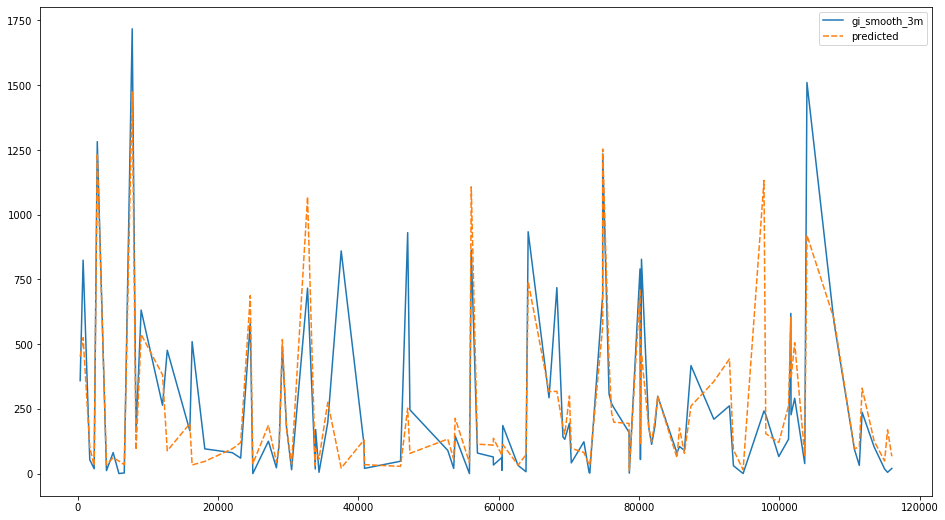

In [29]:
# Set the width and height of the figure
plt.figure(figsize=(16,9))
tmp = y_valid.copy()
tmp['predicted'] = predictions_1
tmp = tmp.iloc[500:600, :]
print(tmp.shape)
# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=tmp)

(100, 2)


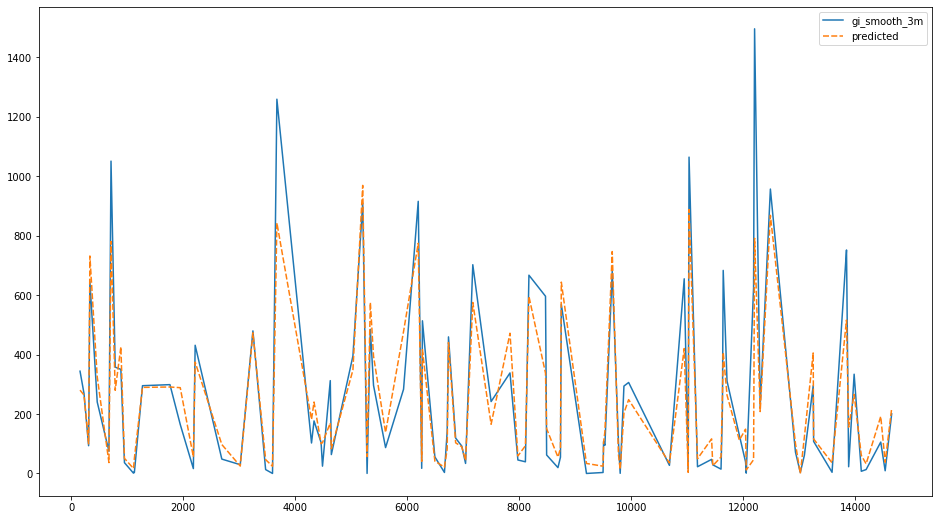

In [114]:
# Set the width and height of the figure
plt.figure(figsize=(16,9))
tmp = y_valid.copy()
tmp['predicted'] = predictions_1
tmp = tmp.iloc[500:600, :]
print(tmp.shape)
# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=tmp)